# King County

In [1]:
%%capture
import sys
!ln -s ../syntheticml .
!{sys.executable} -m pip install -r ../requirements.txt
!{sys.executable} -m pip install -U kaleido
!{sys.executable} -m pip install git+https://github.com/mostly-ai/virtualdatalab.git

In [2]:
import pandas as pd
df = pd.read_csv('../datasets/kingcounty/raw/kc_house_data.csv');
df.sample(3)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
1459,3275860270,20141022T000000,755000.0,3,2.25,3020,13031,2.0,0,0,...,9,3020,0,1989,0,98052,47.6897,-122.098,2480,10204
8965,2883200961,20140605T000000,700000.0,3,1.75,1910,4800,1.0,0,0,...,7,1080,830,1959,0,98103,47.6844,-122.332,1750,4800
19234,1324079029,20150317T000000,200000.0,3,1.00,960,213008,1.0,0,0,...,6,960,0,1933,0,98024,47.5621,-121.862,1520,57499


In [3]:
%%capture
from syntheticml.data.synthetic import Synthetic, MODELS
syn = Synthetic(df, 
        id="id",
        #category_columns=("condition", "floors", "grade", "view", "waterfront", "yr_built", "yr_renovated", "zipcode", "bathrooms", "bedrooms",),
        category_columns=("condition", "floors", "grade", "view", "waterfront", "zipcode", "bathrooms", "bedrooms",),
        exclude_columns=('date',),
        synthetic_folder = "../datasets/kingcounty/synth",
        models=MODELS.keys(),
        target_column="price",
        n_sample = 21613,
        max_cpu_pool=1
)

In [4]:
%%capture  --no-display
syn.process()

syn.process_scores()


## Metricas
### Continuas

In [5]:
metrics = syn.current_metrics()
metrics[~metrics.is_categorical].dropna(axis=1, how='all')

,name,top5,top5_freq,top5_prob,is_categorical,nobs,missing,mean,std_err,upper_ci,...,mode_freq,median,0.1%,1.0%,5.0%,25.0%,75.0%,95.0%,99.0%,99.9%
0,yr_built,"[2014, 2005, 2006, 2004, 2007]","[449, 371, 366, 350, 347]","[0.025968768074031232, 0.02145748987854251, 0....",False,17290.0,0.0,1971.108329,0.223859,1971.547085,...,0.025969,1975.0000,1900.000000,1904.000000,1915.0000,1951.000,1997.000,2.011000e+03,2.014000e+03,2.015000e+03
3,sqft_lot,"[5000, 4000, 6000, 7200, 4800]","[301, 209, 208, 179, 98]","[0.017408906882591092, 0.012087912087912088, 0...",False,17290.0,0.0,14798.947368,295.374719,15377.871180,...,0.017409,7600.0000,737.156000,1005.000000,1756.0000,5001.250,10606.750,4.299910e+04,2.121922e+05,4.356000e+05
4,long,"[-122.29, -122.362, -122.288, -122.3, -122.372]","[100, 88, 81, 81, 81]","[0.00578368999421631, 0.005089647194910353, 0....",False,17290.0,0.0,-122.214139,0.001068,-122.212045,...,0.005784,-122.2310,-122.497000,-122.408000,-122.3870,-122.329,-122.125,-1.219790e+02,-1.217870e+02,-1.216989e+02
5,yr_renovated,"[0, 2014, 2005, 2000, 2003]","[16571, 76, 32, 30, 29]","[0.9584152689415847, 0.004395604395604396, 0.0...",False,17290.0,0.0,83.003412,3.030640,88.943358,...,0.958415,0.0000,0.000000,0.000000,0.0000,0.000,0.000,0.000000e+00,2.008000e+03,2.014000e+03
6,sqft_above,"[1300, 1010, 1200, 1220, 1140]","[166, 165, 160, 152, 148]","[0.009600925390399074, 0.009543088490456911, 0...",False,17290.0,0.0,1785.962175,6.248515,1798.209039,...,0.009601,1560.0000,520.000000,700.000000,850.0000,1200.000,2200.000,3.380000e+03,4.371100e+03,6.070000e+03
7,sqft_basement,"[0, 600, 700, 500, 800]","[10553, 182, 169, 167, 164]","[0.6103528050896472, 0.010526315789473684, 0.0...",False,17290.0,0.0,287.932736,3.336545,294.472244,...,0.610353,0.0000,0.000000,0.000000,0.0000,0.000,550.000,1.180000e+03,1.650000e+03,2.324220e+03
12,sqft_living,"[1400, 1300, 1720, 1250, 1540]","[109, 107, 106, 106, 105]","[0.006304222093695778, 0.006188548293811452, 0...",False,17290.0,0.0,2073.894910,6.900053,2087.418766,...,0.006304,1910.0000,522.890000,720.000000,940.0000,1430.000,2540.000,3.740000e+03,4.921100e+03,6.965550e+03
15,sqft_living15,"[1440, 1540, 1560, 1500, 1610]","[156, 154, 152, 137, 136]","[0.009022556390977444, 0.008906882591093117, 0...",False,17290.0,0.0,1982.904569,5.180812,1993.058774,...,0.009023,1840.0000,740.000000,950.000000,1140.0000,1480.000,2360.000,3.280000e+03,4.050000e+03,4.985550e+03
16,sqft_lot15,"[5000, 4000, 6000, 7200, 4800]","[349, 289, 224, 160, 120]","[0.02018507807981492, 0.016714864083285135, 0....",False,17290.0,0.0,12725.059341,209.331173,13135.340900,...,0.020185,7615.0000,886.289000,1189.000000,1965.0000,5083.000,10046.000,3.682165e+04,1.682959e+05,3.069984e+05
17,price,"[350000.0, 450000.0, 425000.0, 550000.0, 32500...","[143, 140, 123, 123, 123]","[0.008270676691729323, 0.008097165991902834, 0...",False,17290.0,0.0,537768.047947,2748.953957,543155.898699,...,0.008271,450000.0000,95000.000000,154467.000000,210000.0000,320150.000,640000.000,1.150000e+06,1.950000e+06,3.331995e+06


### Categoricas

In [6]:
metrics[metrics.is_categorical].dropna(axis=1, how='all')

,name,top5,top5_freq,top5_prob,is_categorical,nobs,missing
1,view,"[0, 2, 3, 1, 4]","[15586, 783, 396, 275, 250]","[0.901445922498554, 0.045286292654713706, 0.02...",True,17290.0,17290.0
2,zipcode,"[98103, 98038, 98115, 98052, 98117]","[489, 473, 462, 459, 455]","[0.028282244071717755, 0.027356853672643146, 0...",True,17290.0,17290.0
8,grade,"[7, 8, 9, 6, 10]","[7201, 4879, 2072, 1620, 915]","[0.4164835164835165, 0.28218623481781374, 0.11...",True,17290.0,17290.0
9,bathrooms,"[2.5, 1.0, 1.75, 2.25, 2.0]","[4333, 3088, 2425, 1621, 1526]","[0.2506072874493927, 0.17860034702139965, 0.14...",True,17290.0,17290.0
10,floors,"[1.0, 2.0, 1.5, 3.0, 2.5]","[8488, 6628, 1523, 517, 128]","[0.4909196067090804, 0.383342972816657, 0.0880...",True,17290.0,17290.0
11,bedrooms,"[3, 4, 2, 5, 6]","[7865, 5477, 2237, 1292, 212]","[0.4548872180451128, 0.3167727009832273, 0.129...",True,17290.0,17290.0
13,condition,"[3, 4, 5, 2, 1]","[11248, 4512, 1364, 139, 27]","[0.6505494505494506, 0.2609600925390399, 0.078...",True,17290.0,17290.0
14,waterfront,"[0, 1]","[17166, 124]","[0.9928282244071718, 0.007171775592828224]",True,17290.0,17290.0


## Scores

In [7]:
best_model = "tddpm_mlp_21613"
second_best_model = "smote-enc_21613"
avg = syn.scores[syn.scores["type"] == "avg"]
avg.sort_values("score", ascending=False).loc[["tddpm_mlp_21613","smote-enc_21613","gaussiancopula_noise_21613","tvae_21613", "tvae_noise_21613","gaussiancopula_21613","copulagan_noise_21613","copulagan_21613","ctgan_noise_21613","ctgan_21613"],["score", "DCR ST 5th", "DCR SH 5th", "DCR TH 5th"]]
#["tddpm_mlp_21613","smote-enc_21613","gaussiancopula_noise_21613","tvae_21613", "tvae_noise_21613","gaussiancopula_21613","copulagan_noise_21613","copulagan_21613","ctgan_noise_21613","ctgan_21613"]

,score,DCR ST 5th,DCR SH 5th,DCR TH 5th
name,,,,
tddpm_mlp_21613,0.967595,0.084193,0.106505,0.03575
smote-enc_21613,0.928393,0.057908,0.089537,0.03575
gaussiancopula_noise_21613,0.854440,0.202568,0.201936,0.03575
tvae_21613,0.843846,0.153342,0.155889,0.03575
tvae_noise_21613,0.840412,0.152183,0.156163,0.03575
gaussiancopula_21613,0.837340,0.199984,0.201602,0.03575
copulagan_noise_21613,0.822024,0.219654,0.215788,0.03575
copulagan_21613,0.800622,0.213740,0.216464,0.03575
ctgan_noise_21613,0.781526,0.210628,0.212446,0.03575


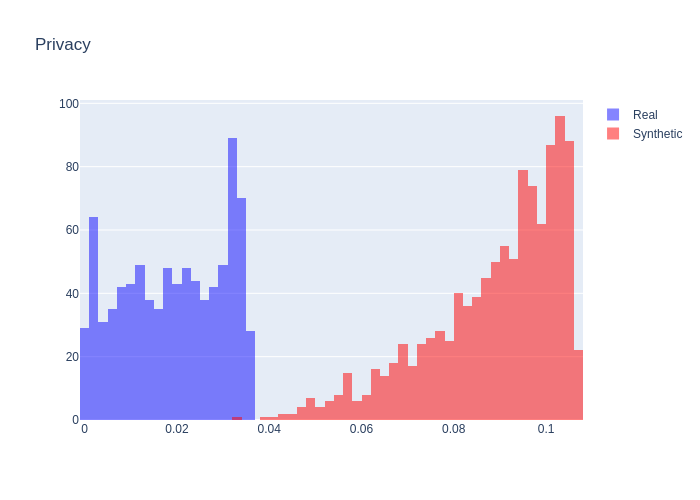

None

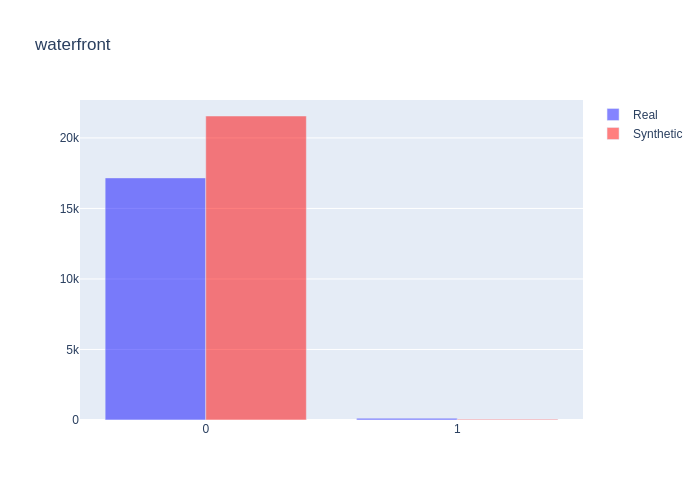

None

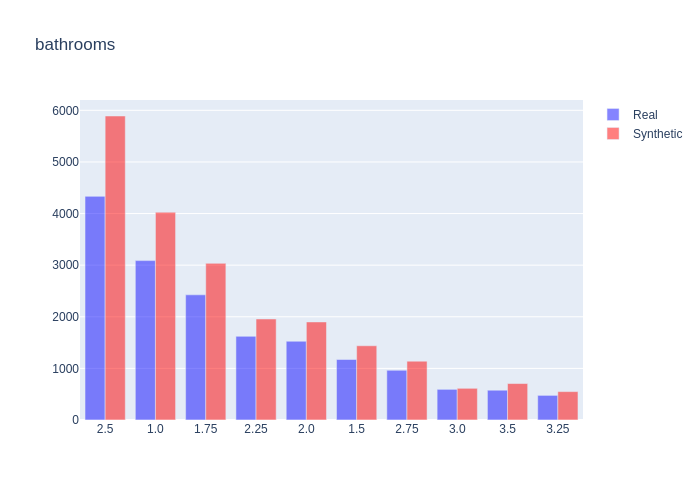

None

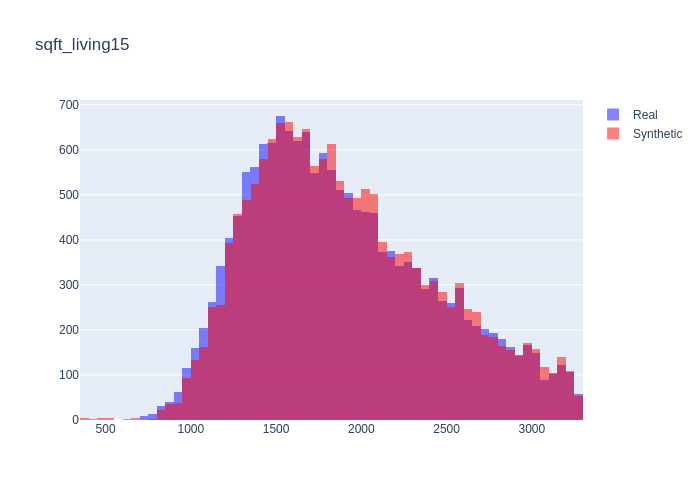

None

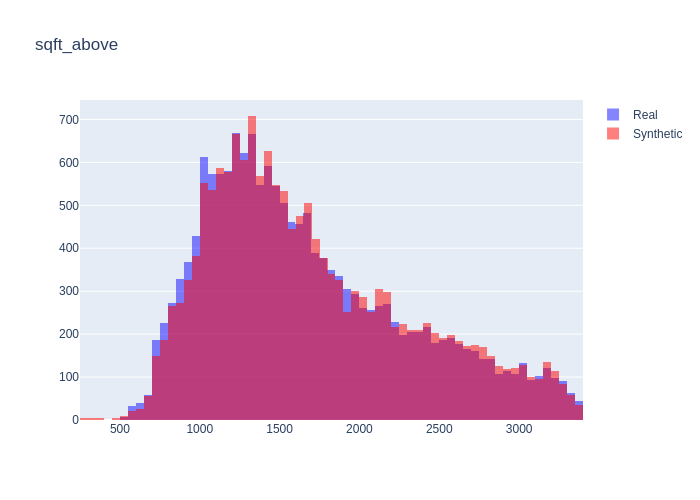

None

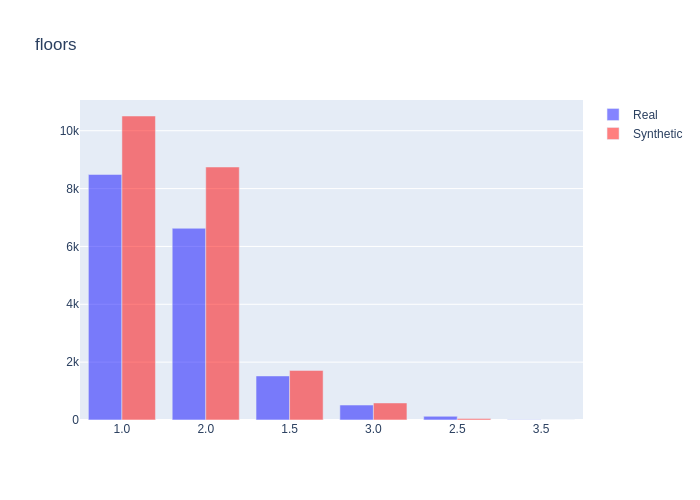

None

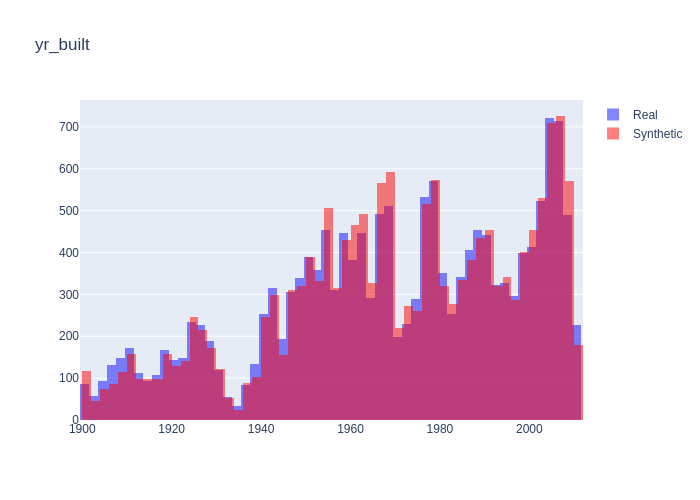

None

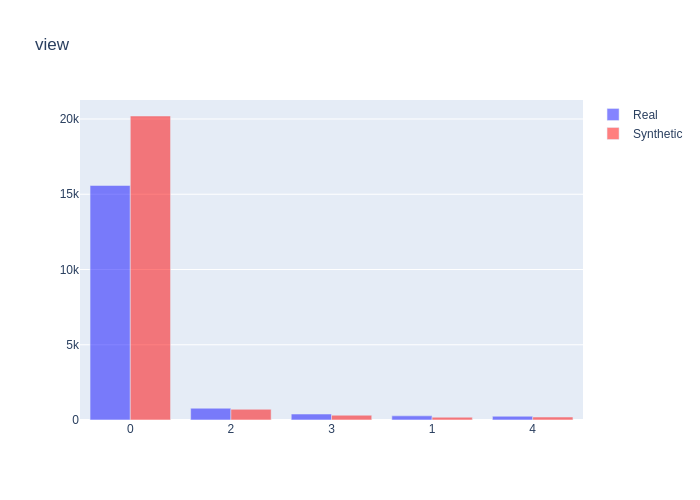

None

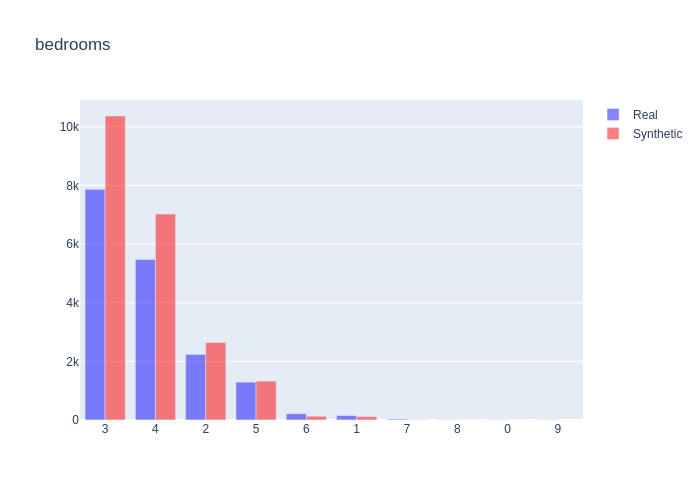

None

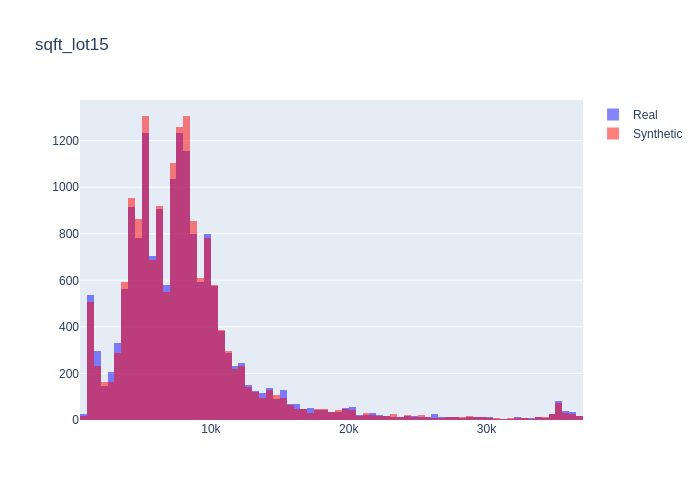

None

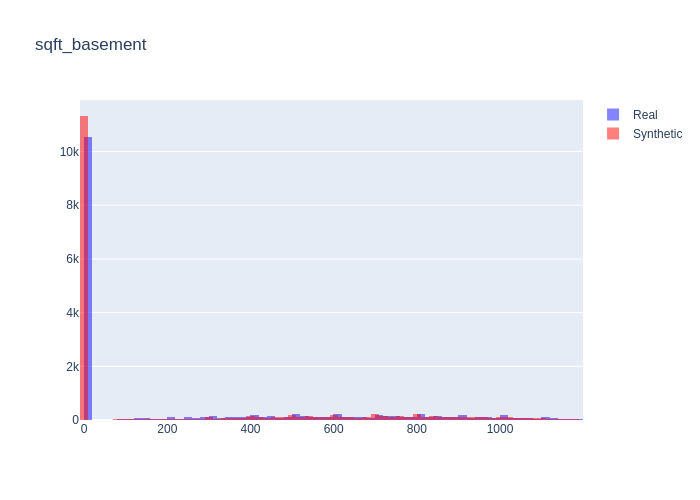

None

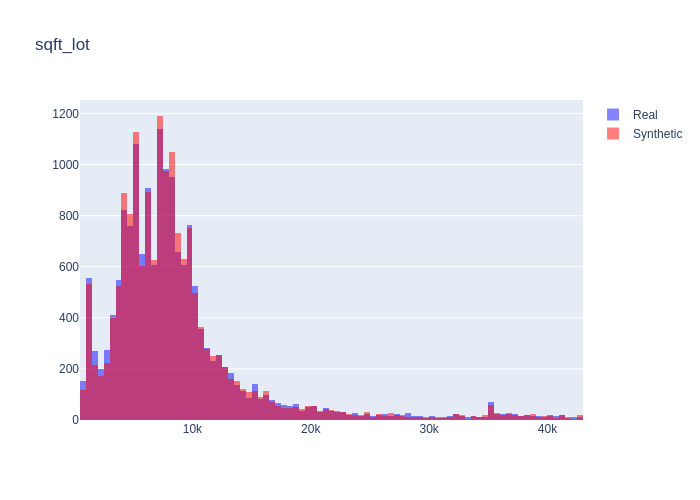

None

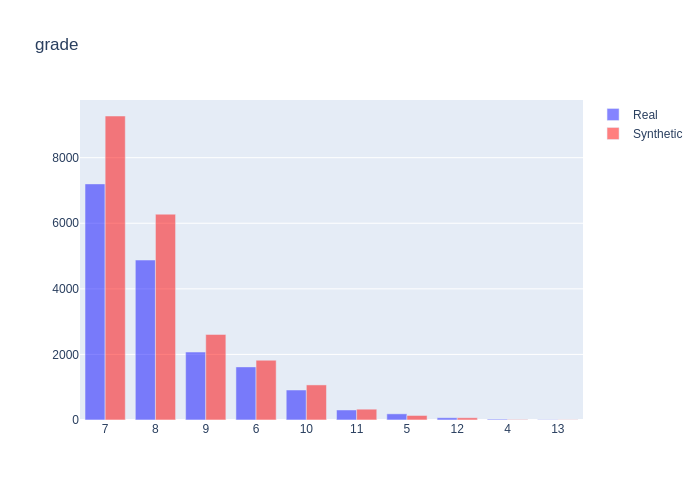

None

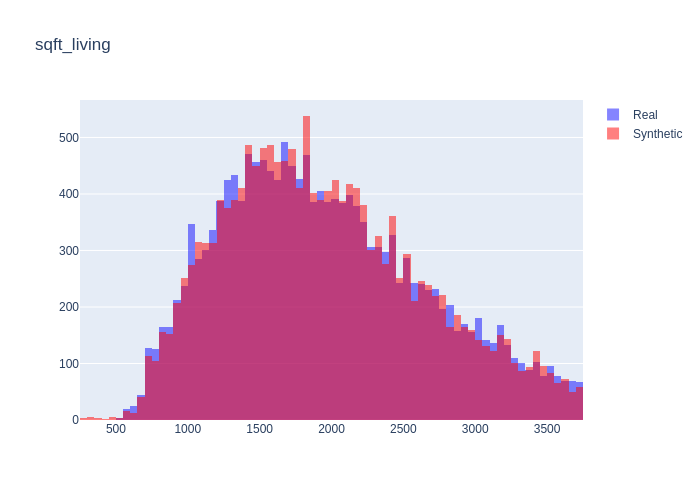

None

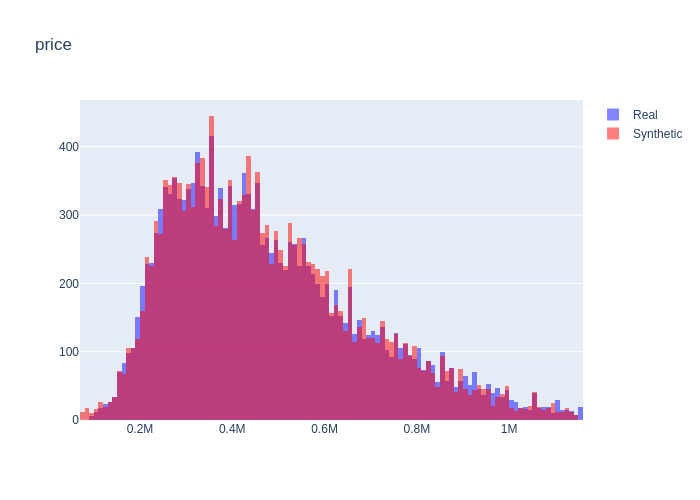

None

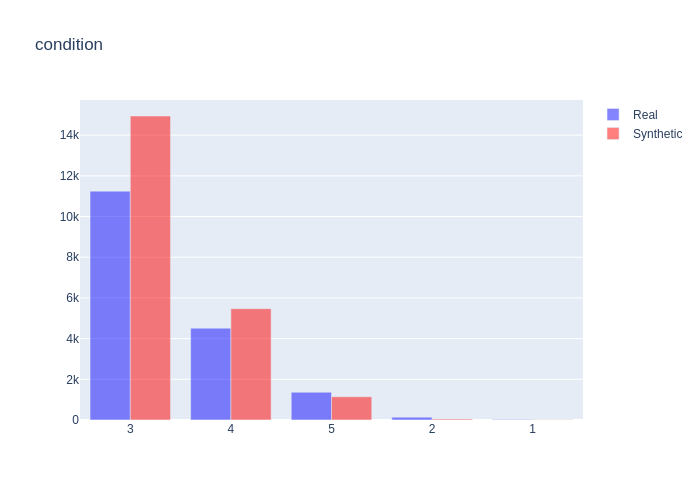

None

In [8]:
from syntheticml.data.charts import Charts
for fig in syn.get_charts(best_model, {'date', 'id', 'zipcode', 'lat', 'long', 'yr_renovated'}):
    if fig:
        display(fig.show("png"))

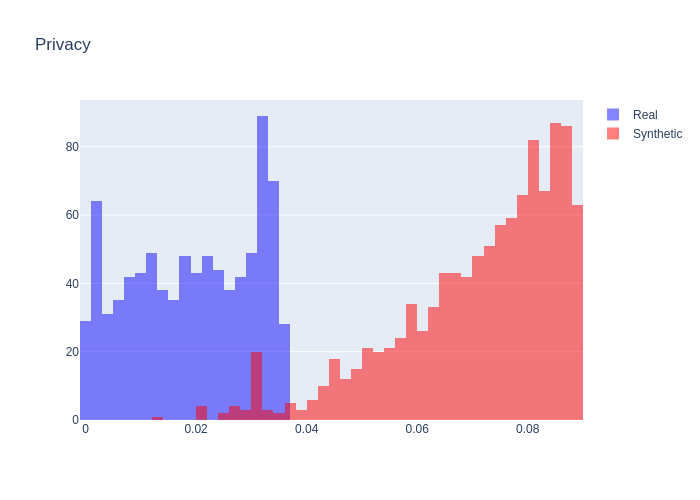

None

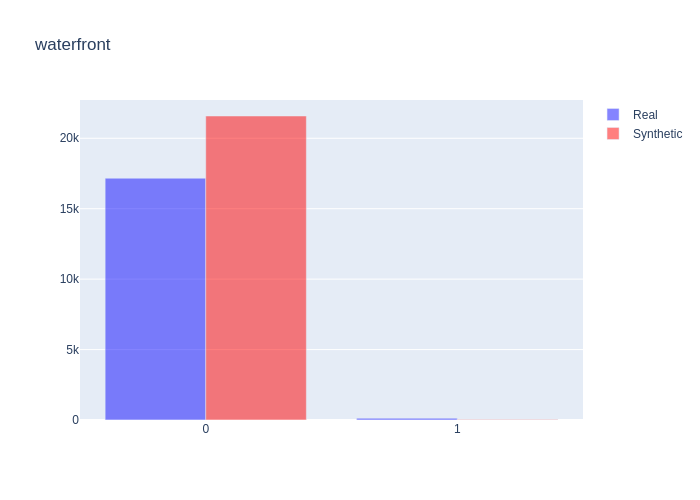

None

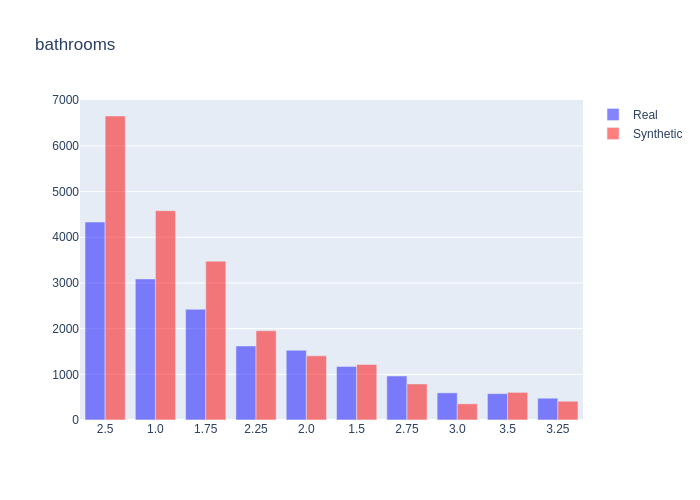

None

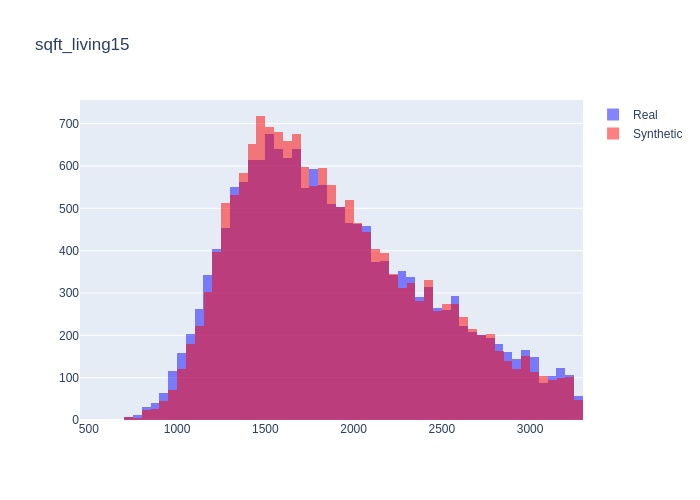

None

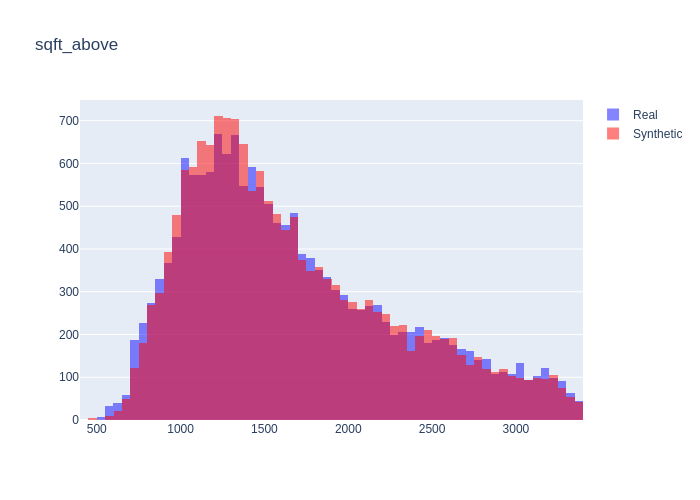

None

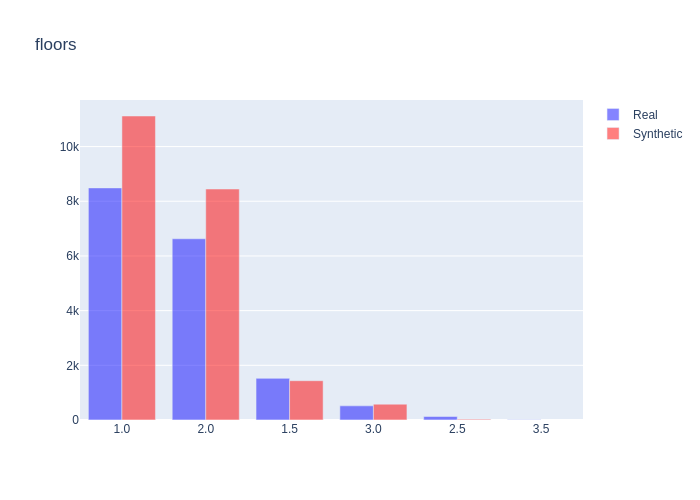

None

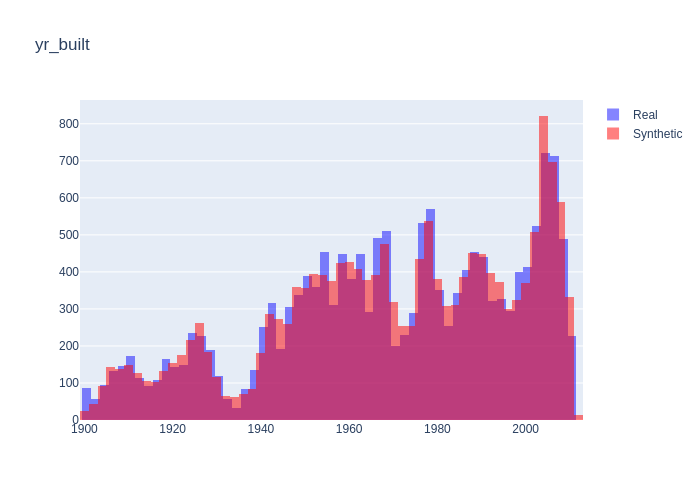

None

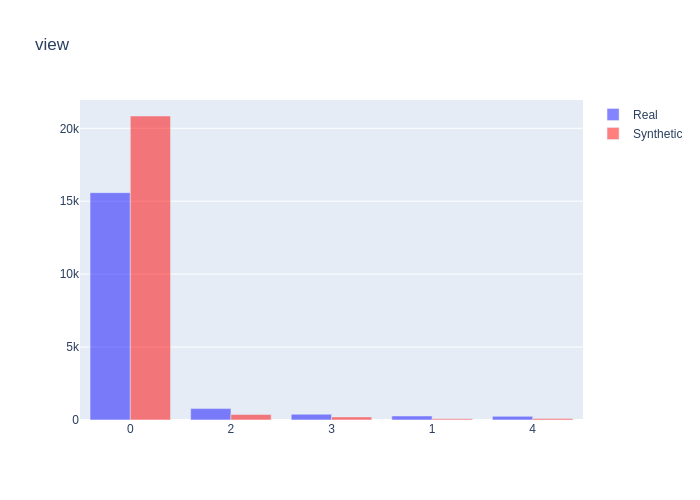

None

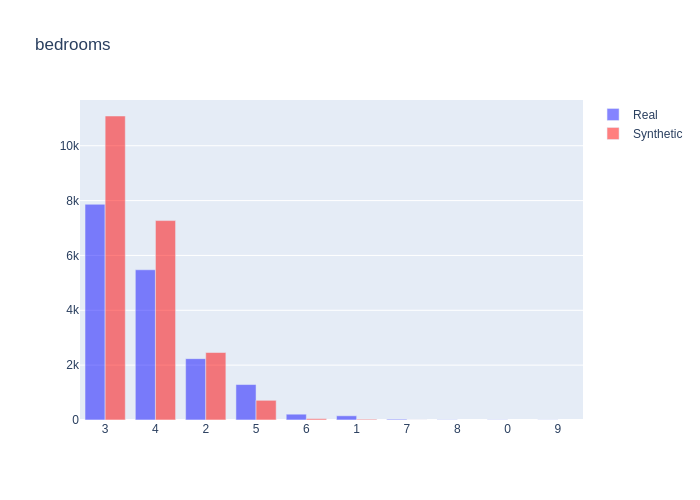

None

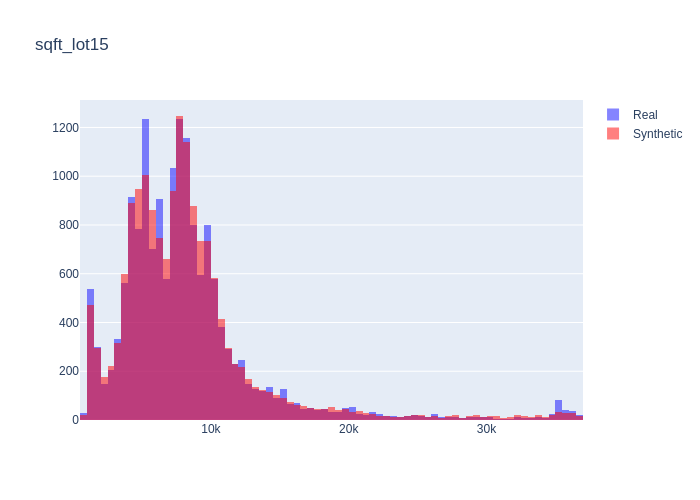

None

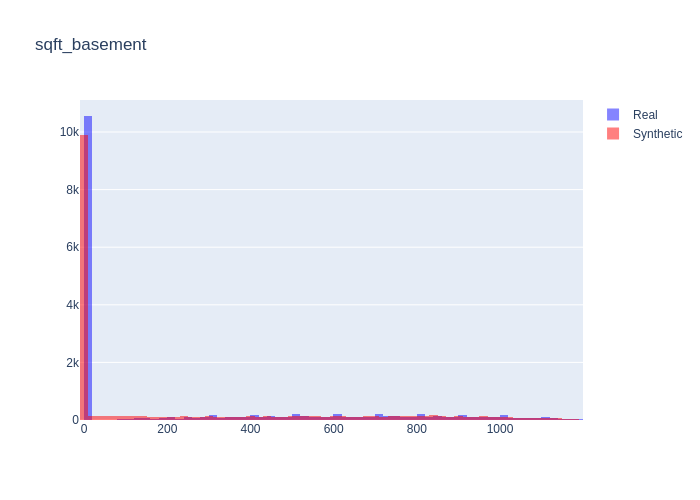

None

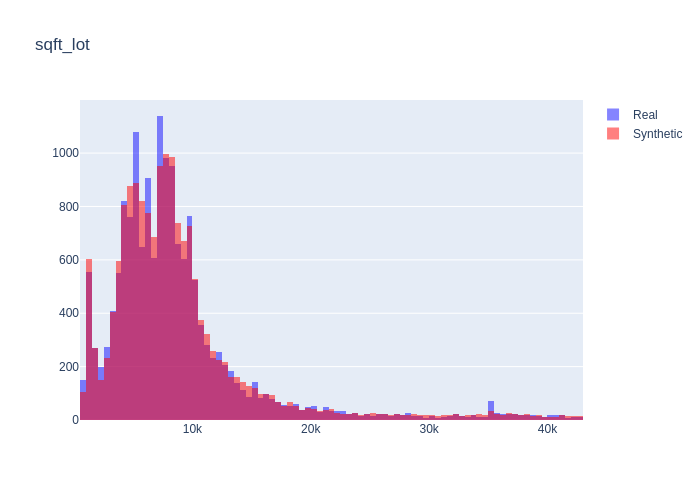

None

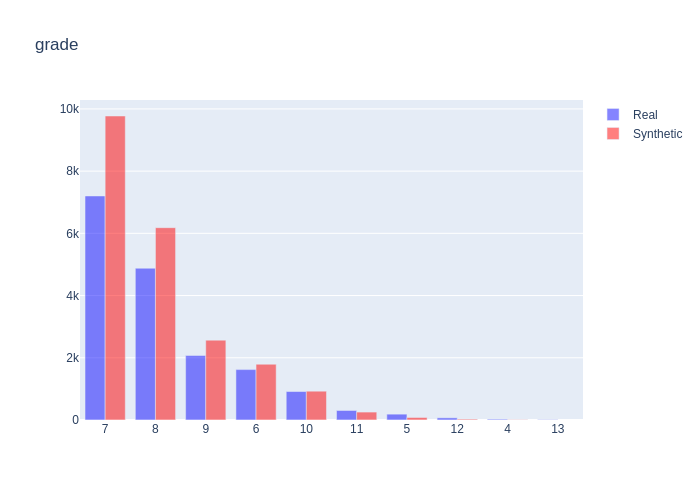

None

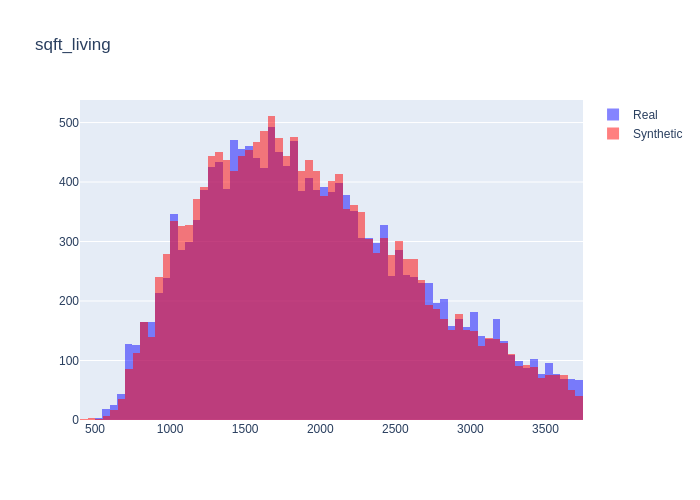

None

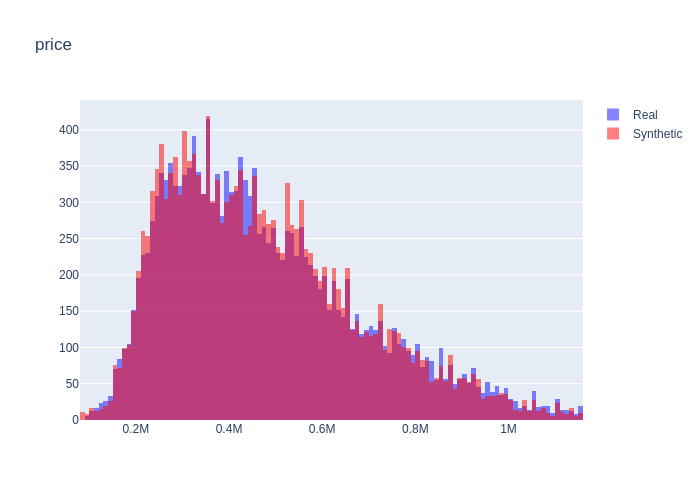

None

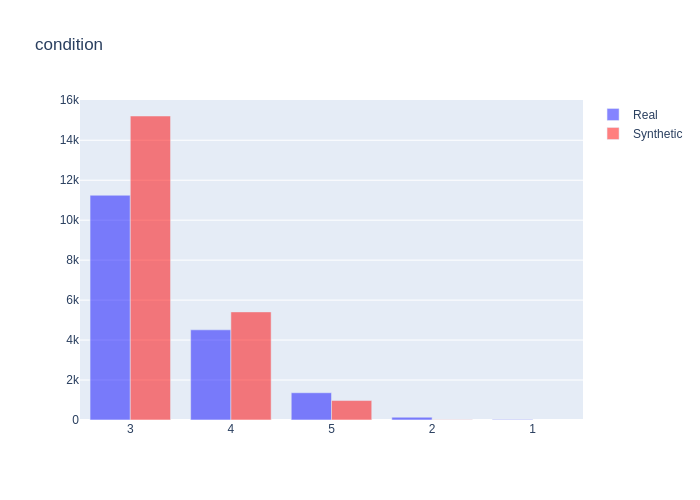

None

In [9]:
from syntheticml.data.charts import Charts
for fig in syn.get_charts(second_best_model, {'date', 'id', 'zipcode', 'lat', 'long', 'yr_renovated'}):
    if fig:
        display(fig.show("png"))

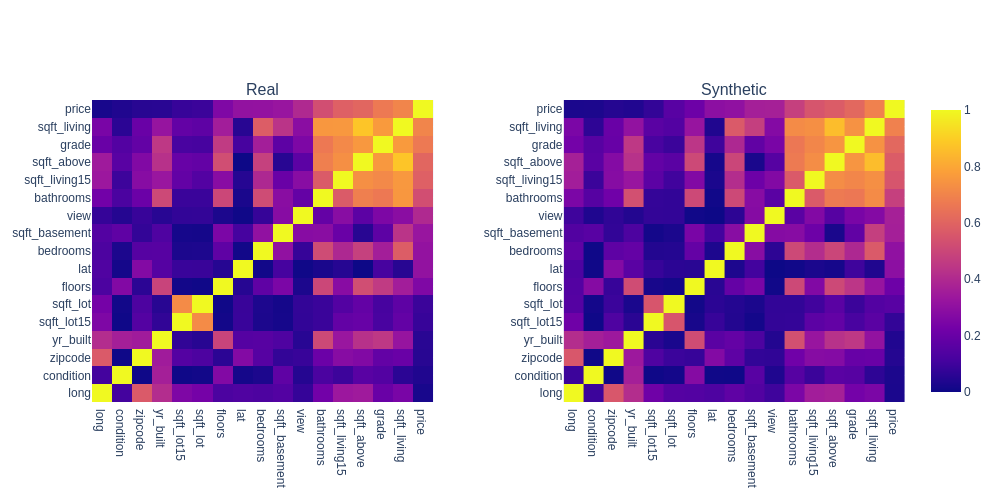

In [10]:
syn.charts.pair_corr(syn.df, syn.fake_data[best_model], {'id', 'waterfront', 'yr_renovated'}, "price").update_layout(dict(width=1000)).show("png")

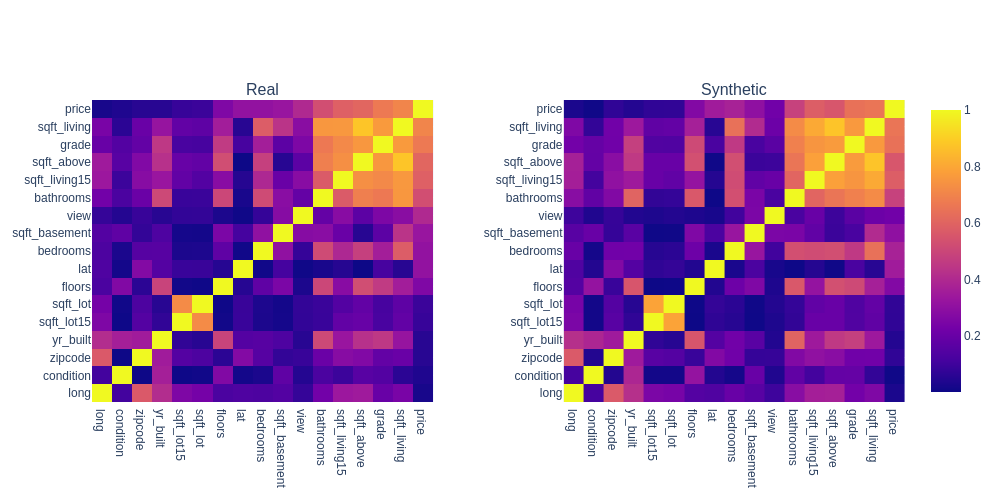

In [11]:
syn.charts.pair_corr(syn.df, syn.fake_data[second_best_model], {'id', 'waterfront', 'yr_renovated'}, "price").update_layout(dict(width=1000)).show("png")